In [191]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [192]:

class NeuralNetwork2:

    def __init__(self, layer_sizes, activation='sigmoid', output_activation='linear', init_method='normal',bias_sd = 0.01):
        """
        Inicjalizuje sieć neuronową MLP.

        :param layer_sizes: Lista określająca liczbę neuronów w kolejnych warstwach, np. [1, 5, 1]
        :param activation: Funkcja aktywacji dla warstw ukrytych (domyślnie 'sigmoid')
        :param output_activation: Funkcja aktywacji dla warstwy wyjściowej (domyślnie 'linear')
        :param init_method: Metoda inicjalizacji wag, opcje:
                            'normal'  - N(0,1) (domyślnie),
                            'uniform' - U[0,1],
                            'he'      - inicjalizacja He,
                            'xavier'  - inicjalizacja Xavier.
                            W przypadku nieznanej metody używana jest inicjalizacja normalna.
        """
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.output_activation = output_activation
        self.init_method = init_method

        # Inicjalizacja parametrów (wag i biasów) dla każdej warstwy poza wejściową
        self.params = []
        for i in range(len(layer_sizes) - 1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]

            if init_method == 'normal':
                # Domyślna inicjalizacja: N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'uniform':
                # Inicjalizacja z U[0,1]
                W = np.random.rand(n_out, n_in)
                b = np.random.rand(n_out, 1) * bias_sd
            elif init_method == 'he':
                # Inicjalizacja He: dla warstw z ReLU lub jej wariantami
                W = np.random.randn(n_out, n_in) * np.sqrt(2 / n_in)
                b = np.random.randn(n_out, 1) * bias_sd
            elif init_method == 'xavier':
                # Inicjalizacja Xavier: dla warstw z sigmoid lub tanh
                W   = np.random.randn(n_out, n_in) * np.sqrt(1 / (n_in + n_out))
                b = np.random.randn(n_out, 1) * bias_sd
            else:
                # W przypadku nieznanej metody używamy domyślnej inicjalizacji N(0,1)
                W = np.random.randn(n_out, n_in)
                b = np.random.randn(n_out, 1) * bias_sd

            self.params.append({'W': W, 'b': b})

    def sigmoid(self, z):
        """
        Funkcja aktywacji sigmoidalnej z ograniczeniem zakresu dla stabilności numerycznej.
        """
        z = np.clip(z, -15, 15)
        return 1.0 / (1.0 + np.exp(-z))

    def relu(self, z):
        """
        Funkcja aktywacji ReLU 
        """  
        return np.maximum(0, z)

    def linear(self, z):
        """
        Funkcja aktywacji liniowej.
        """
        return z

    def forward(self, X):
        """
        Przeprowadza propagację w przód.

        :param X: Dane wejściowe w postaci macierzy [D x N] (D - cechy, N - liczba próbek)
        :return: Wynik propagacji (output sieci)
        """
        # Propagacja przez warstwy ukryte

        activation_func = getattr(self, self.activation)
        for i in range(len(self.layer_sizes) - 2):
            X = activation_func(self.params[i]['W'] @ X + self.params[i]['b'])

        # Warstwa wyjściowa z określoną funkcją aktywacji
        output_func = getattr(self, self.output_activation)
        return output_func(self.params[-1]['W'] @ X + self.params[-1]['b'])

    def compute_loss(self, y_true, y_pred):
        """
        Oblicza funkcję kosztu (MSE).

        MSE = (1/N) * sum((y_pred - y_true)^2)
        """
        y_true = y_true.flatten()
        y_pred = y_pred.flatten()
        N = y_true.shape[0]
        return (1 / N) * np.sum((y_pred - y_true) ** 2)

    
    '''
    def calculate_gradient(self, x_batch, y_batch, eps=1e-8):
        """
        Oblicza gradienty wag i biasów metodą różnic skończonych.

        :param x_batch: Dane wejściowe dla batcha
        :param y_batch: Odpowiedzi dla batcha
        :param eps: Małe przesunięcie do obliczeń numerycznych
        :return: Lista gradientów dla poszczególnych warstw
        """
        gradients = []
        for layer in self.params:
            layer_grad = {}
            for key in ['W', 'b']:
                param = layer[key]
                grad_param = np.zeros_like(param)
                for index in np.ndindex(param.shape):
                    original_val = param[index]

                    # Obliczenie po przesunięciu dodatnim
                    param[index] = original_val + eps
                    loss_plus = self.compute_loss(y_batch, self.forward(x_batch))

                    # Obliczenie po przesunięciu ujemnym
                    param[index] = original_val - eps
                    loss_minus = self.compute_loss(y_batch, self.forward(x_batch))

                    grad_param[index] = (loss_plus - loss_minus) / (2 * eps)
                    param[index] = original_val  # Przywrócenie oryginalnej wartości

                layer_grad[key] = grad_param
            gradients.append(layer_grad)
        return gradients
    '''


    def calculate_gradient(self, x_batch, y_batch, clip_threshold=1.0):
        """
        Oblicza gradienty wag i biasów metodą backpropagation z gradient clipping.
    
        :param x_batch: Dane wejściowe dla batcha w postaci macierzy [D x N],
                        gdzie D - liczba cech, N - liczba próbek.
        :param y_batch: Odpowiedzi dla batcha (wektor lub macierz [output_size x N])
        :param clip_threshold: Próg normy, powyżej którego gradienty są skalowane.
        :return: Lista gradientów dla poszczególnych warstw, 
                 gdzie każdy element to słownik {'W': gradient_wag, 'b': gradient_biasów}
        """

        # Forward pass – zapisujemy aktywacje i wartości przed funkcją aktywacji (pre-activations)
        activations = [x_batch]  # a^(0) = x_batch
        zs = []                # lista przechowująca z = W*a + b dla każdej warstwy
        for i in range(len(self.params)):
            z = self.params[i]['W'] @ activations[-1] + self.params[i]['b']
            zs.append(z)
            # Dla warstw ukrytych używamy funkcji określonej przez self.activation,
            # a dla warstwy wyjściowej funkcji self.output_activation
            if i < len(self.params) - 1:
                a = getattr(self, self.activation)(z)
            else:
                a = getattr(self, self.output_activation)(z)
            activations.append(a)
        
        # Upewnij się, że y_batch ma taki sam kształt jak output sieci
        if y_batch.ndim == 1:
            y_batch = y_batch.reshape(activations[-1].shape)
        
        m = x_batch.shape[1]  # liczba próbek w batchu

        # Obliczenie początkowego delta na podstawie MSE, pochodna z mse po aktywacji
        delta = (2.0 / m) * (activations[-1] - y_batch)
        
        # Modyfikacja delta przez pochodną funkcji aktywacji warstwy wyjściowej
        # domnazamy pochodna z po aktywacji
        if self.output_activation == 'linear':
            pass  # dla liniowej pochodna = 1, czyli bez zmian
        elif self.output_activation == 'sigmoid':
            delta = delta * (activations[-1] * (1 - activations[-1]))
        elif self.output_activation == 'relu':
            delta = delta * (zs[-1] > 0).astype(float)
        else:
            pass  # domyślnie pozostawiamy bez zmian



        # Obliczenie gradientów dla warstwy wyjściowej
        gradients = [None] * len(self.params)
        dW = delta @ activations[-2].T
        db = np.sum(delta, axis=1, keepdims=True)
        gradients[-1] = {'W': dW, 'b': db}
        
        # Backpropagation przez warstwy ukryte
        for i in range(len(self.params) - 2, -1, -1):
            delta = self.params[i+1]['W'].T @ delta
            if self.activation == 'sigmoid':
                delta = delta * (activations[i+1] * (1 - activations[i+1]))
            elif self.activation == 'relu':
                delta = delta * (zs[i] > 0).astype(float)
            else:
                pass  # dla liniowych funkcji aktywacji nie zmieniamy delta
            dW = delta @ activations[i].T
            db = np.sum(delta, axis=1, keepdims=True)
            gradients[i] = {'W': dW, 'b': db}
        
        # Gradient clipping – skalujemy każdy gradient jeśli jego norma przekracza clip_threshold
        # maksymalna norma layera czy to biasu czy wag ma byc 1
        for layer_grad in gradients:
            for key in layer_grad:
                grad_norm = np.linalg.norm(layer_grad[key])
                if grad_norm > clip_threshold:
                    layer_grad[key] = layer_grad[key] * (clip_threshold / grad_norm)
        
        return gradients

    def train(self, X_train, y_train, batch_size, epochs, learning_rate=0.01,
              save_weights_history=False, measure_time=False, verbose=250):
        """
        Trenuje sieć neuronową metodą mini-batch gradient descent.

        Jeśli parametr save_weights_history jest ustawiony na True, to po każdej epoce zapisywana jest historia wag
        (lista "snapshotów" wag po każdym batchu) i zwracana jako lista list.

        Jeśli parametr measure_time jest ustawiony na True, funkcja mierzy i wyświetla czas wykonania każdego batcha
        oraz całej epoki.

        :param X_train: Dane treningowe [D x N]
        :param y_train: Etykiety treningowe (wektor)
        :param batch_size: Rozmiar mini-batcha
        :param epochs: Liczba epok treningowych
        :param learning_rate: Współczynnik uczenia
        :param save_weights_history: Flaga określająca, czy zapisywać historię wag (domyślnie False)
        :param measure_time: Flaga określająca, czy mierzyć czas wykonania batcha i epoki (domyślnie False)
        """


        num_samples = X_train.shape[1]
        weights_history = [] if save_weights_history else None
        epoch_time_history = [] if measure_time else None
        batch_time_history = [] if measure_time else None

        for epoch in range(epochs):
            if measure_time:
                epoch_start_time = time.perf_counter()
                epoch_batch_times = []  # Lista czasów batchy dla bieżącej epoki
            epoch_weights = [] if save_weights_history else None
            indices = np.random.permutation(num_samples)
            for start_idx in range(0, num_samples, batch_size):
                if measure_time:
                    batch_start_time = time.perf_counter()
                end_idx = min(start_idx + batch_size, num_samples)
                batch_indices = indices[start_idx:end_idx]

                X_batch = X_train[:, batch_indices]
                y_batch = y_train[batch_indices]

                gradients = self.calculate_gradient(X_batch, y_batch)
                for i in range(len(self.params)):
                    self.params[i]['W'] -= learning_rate * gradients[i]['W']
                    self.params[i]['b'] -= learning_rate * gradients[i]['b']

                if save_weights_history:
                    snapshot = []
                    for param in self.params:
                        snapshot.append({'W': param['W'].copy(), 'b': param['b'].copy()})
                    epoch_weights.append(snapshot)

                if measure_time:
                    batch_end_time = time.perf_counter()
                    batch_duration = batch_end_time - batch_start_time
                    epoch_batch_times.append(batch_duration)

            if measure_time:
                epoch_end_time = time.perf_counter()
                epoch_duration = epoch_end_time - epoch_start_time
                epoch_time_history.append(epoch_duration)
                batch_time_history.append(epoch_batch_times)  # Dodajemy listę czasów batchy dla danej epoki
            if save_weights_history:
                weights_history.append(epoch_weights)

            if epoch % verbose == 0:
                y_pred = self.forward(X_train)
                loss = self.compute_loss(y_train, y_pred)
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss}")

        final_loss = self.compute_loss(y_train, self.forward(X_train))
        print(f"Final Loss: {final_loss}")

        return weights_history, epoch_time_history, batch_time_history



In [193]:
def plot_xy_scatter(data, title='y = f(x)'):
    """
    Tworzy wykres punktowy dla danych zawierających kolumny 'x' oraz 'y'.

    Parameters:
    - data: DataFrame z kolumnami 'x' oraz 'y'
    - title: tytuł wykresu (domyślnie 'y = f(x)')
    """
    plt.figure(figsize=(6, 4))
    plt.scatter(data['x'], data['y'], s=20)  # s określa rozmiar punktów
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [194]:
def plot_results(x_test, y_test, y_pred):
    """
    Funkcja tworzy wykres punktowy porównujący
    wartości rzeczywiste (y_test) i przewidywane (y_pred)
    w zależności od x_test.
    
    Parametry:
    -----------
    x_test : array-like, shape (n_samples,)
        Jednowymiarowy wektor cechy (po skalowaniu).
    y_test : array-like, shape (n_samples,)
        Rzeczywiste wartości wyjściowe.
    y_pred : array-like, shape (n_samples,)
        Przewidywane wartości wyjściowe (po odskalowaniu).
    """

    plt.figure(figsize=(8, 5))
    
    # Wykres punktowy wartości rzeczywistych
    plt.scatter(x_test, y_test, color='blue', label='y_test')
    
    # Wykres punktowy wartości przewidywanych
    plt.scatter(x_test, y_pred, color='red', label='y_pred')
    
    plt.xlabel("x_test_scaled_2")
    plt.ylabel("Wartości y")
    plt.title("Porównanie wartości rzeczywistych i przewidywanych")
    plt.legend()
    plt.grid(True)
    plt.show()

In [195]:

def load_and_scale_data(training_csv, test_csv, feature_col='x', target_col='y'):
    """
    Wczytuje dane z plików CSV oraz skaluje je (standaryzacja).

    Parametry:
      - training_csv: Ścieżka do pliku CSV z danymi treningowymi.
      - test_csv: Ścieżka do pliku CSV z danymi testowymi.
      - feature_col: Nazwa kolumny zawierającej cechy (domyślnie 'x').
      - target_col: Nazwa kolumny zawierającej etykiety (domyślnie 'y').

    Zwraca:
      - x_train_scaled: Zescalowane dane treningowe (features) [1 x N_train].
      - y_train_scaled: Zescalone etykiety treningowe.
      - x_test_scaled: Zescalowane dane testowe (features) [1 x N_test].
      - y_test: Oryginalne etykiety testowe (bez skalowania).
      - scaling_params: Krotka (x_mean, x_std, y_mean, y_std) – parametry skalowania,
                        które później można użyć do odwrotnej transformacji wyników.
    """
    # Wczytanie danych


    # Wyodrębnienie kolumn i przekształcenie do odpowiednich kształtów
    x_train = training_csv[[feature_col]].values.T
    y_train = training_csv[target_col].values

    x_test = test_csv[[feature_col]].values.T
    y_test = test_csv[target_col].values

    # Obliczanie średniej i odchylenia standardowego dla x oraz y
    x_mean = np.mean(x_train)
    x_std  = np.std(x_train)
    y_mean = np.mean(y_train)
    y_std  = np.std(y_train)

    # Skalowanie danych (standaryzacja)
    x_train_scaled = (x_train - x_mean) / x_std
    y_train_scaled = (y_train - y_mean) / y_std
    x_test_scaled  = (x_test - x_mean) / x_std

    scaling_params = (x_mean, x_std, y_mean, y_std)
    return x_train_scaled, y_train_scaled, x_test_scaled, y_test, scaling_params

In [196]:
def save_dict(neural_network, file_name="data/NN2/weights_multimodal_large.txt"):
    """
    Zapisuje parametry sieci (neural_network_2.params) do pliku w formie tekstowej.

    Parametry:
    - neural_network_2: obiekt zawierający atrybut params (np. listę słowników z 'W' i 'b').
    - nazwa_pliku (str): nazwa (lub ścieżka) pliku wyjściowego.
    """
    with open(file_name, "w", encoding="utf-8") as f:
        # Używamy repr, aby zachować formę 'array([...])', co ułatwi późniejsze wczytanie evalem.
        f.write(repr(neural_network.params))

In [197]:
def read_dict(file_name):
    """
    This function reads the contents of a text file containing a list of dictionaries.
    Each dictionary includes the keys 'W' and 'b', with their values represented as numpy arrays.

    Parameters:
        file_name (str): Path to the text file.

    Returns:
        list: A list of dictionaries with the data.
    """
    with open(file_name, 'r', encoding='utf-8') as f:
        content = f.read()

    # Using eval with restricted globals to allow only numpy.array
    data = eval(content, {"__builtins__": None}, {"array": np.array})
    return data

In [198]:
steps_small_training = pd.read_csv("data/NN2/steps-small-training.csv")
steps_small_test = pd.read_csv("data/NN2/steps-small-test.csv")

square_simple_training = pd.read_csv("data/NN2/square-simple-training.csv")
square_simple_test = pd.read_csv("data/NN2/square-simple-test.csv")

multimodal_large_training = pd.read_csv("data/NN2/multimodal-large-training.csv")
multimodal_large_test = pd.read_csv("data/NN2/multimodal-large-test.csv")


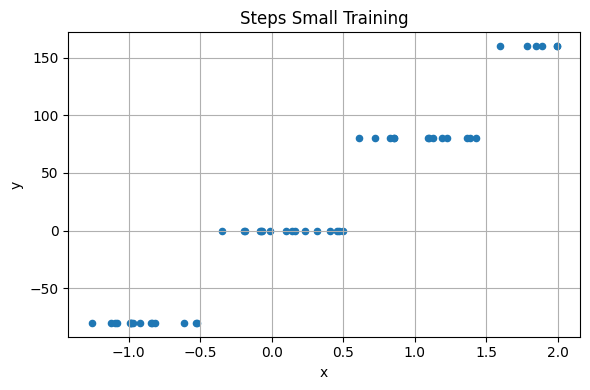

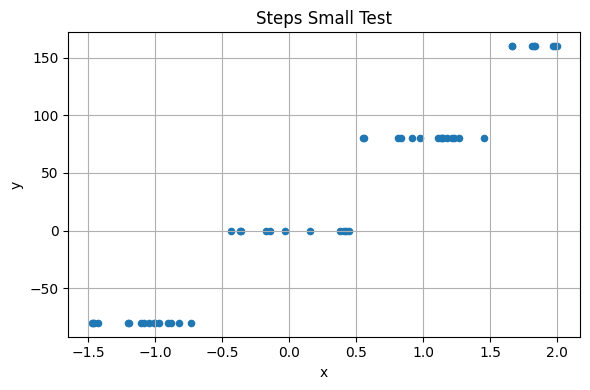

In [199]:
# Przykładowe wywołania funkcji dla poszczególnych zbiorów danych:
plot_xy_scatter(steps_small_training, title='Steps Small Training')
plot_xy_scatter(steps_small_test, title='Steps Small Test')

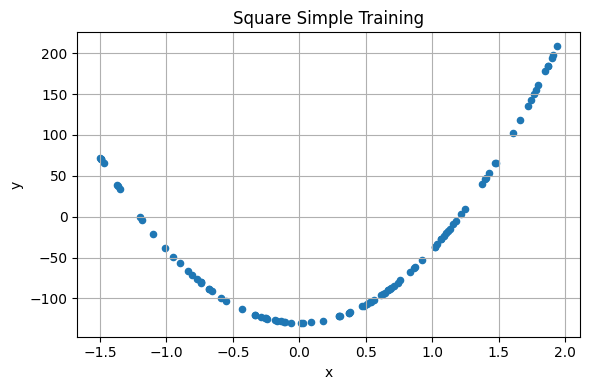

In [200]:
plot_xy_scatter(square_simple_training, title='Square Simple Training')

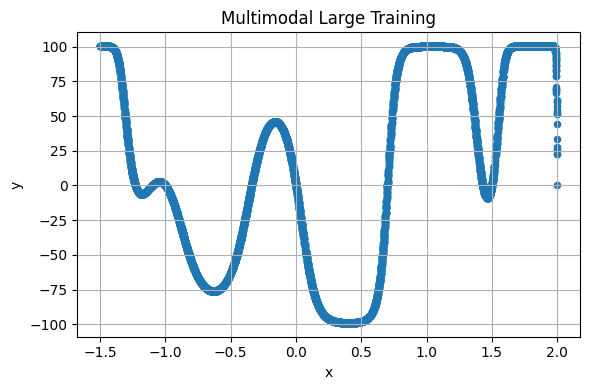

In [201]:
plot_xy_scatter(multimodal_large_training, title='Multimodal Large Training')

# steps_small

In [202]:
neural_network_0 = NeuralNetwork2(layer_sizes=[1,16,16,16,16,1],
                                  activation='relu',
                                  output_activation='linear',
                                  init_method='he')

x_train_scaled_0, y_train_scaled_0,  x_test_scaled_0, y_test_0, scaling_params_0 =  load_and_scale_data(steps_small_training,
                                                                                                        steps_small_test, 'x','y')

neural_network_0.params = read_dict('data/NN2/weights_steps_small.txt')

In [203]:
'''
weights_history_0, epoch_time_history_0, batch_time_history_0 =  neural_network_0.train(x_train_scaled_0, y_train_scaled_0, batch_size = 10 ,epochs = 20000, learning_rate=0.01, save_weights_history=True, measure_time=True, verbose = 5000)
'''

'\nweights_history_0, epoch_time_history_0, batch_time_history_0 =  neural_network_0.train(x_train_scaled_0, y_train_scaled_0, batch_size = 10 ,epochs = 20000, learning_rate=0.01, save_weights_history=True, measure_time=True, verbose = 5000)\n'

In [204]:
save_dict(neural_network_0,'data/NN2/weights_steps_small.txt')

In [205]:
y_predict_0 = neural_network_0.forward(x_test_scaled_0)
y_test_mean_0 = scaling_params_0[2]
y_test_sd_0 = scaling_params_0[3]
y_predict_rescaled_0 = y_predict_0 * y_test_sd_0 + y_test_mean_0
neural_network_0.compute_loss(y_test_0, y_predict_rescaled_0)

np.float64(209.01026726415864)

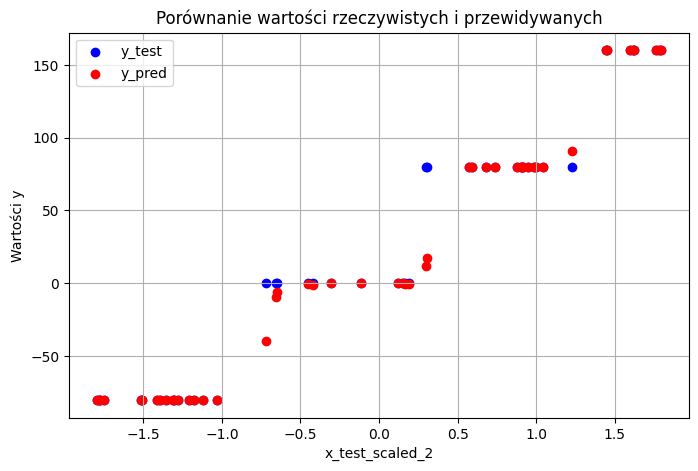

In [206]:
plot_results(x_test_scaled_0, y_test_0,  y_predict_rescaled_0)

## nie da rady, bo....


### Na zbiorze testowym występują obserwacje, które nie były obecne w zbiorze uczącym. Na przykład, wartości x odpowiadające prognozom y_pred, odbiegającym od zbioru {-80, 0, 80, 160}, nie zostały uwzględnione podczas treningu. W konsekwencji model ma trudności z przypisywaniem właściwych wartości – w praktyce „zgaduje” na podstawie wcześniej widzianych danych. Powoduje to wyższy błąd na zbiorze testowym oraz uniemożliwia obniżenie straty do oczekiwanego poziomu.

# square_simple

In [207]:

neural_network_1 = NeuralNetwork2(layer_sizes=[1,10,1],
                                          activation='sigmoid',
                                          output_activation='linear',
                                          init_method='xavier')


neural_network_1.params = read_dict('data/NN2/weights_square_simple.txt')

x_train_scaled_1, y_train_scaled_1, x_test_scaled_1, y_test_1, scaling_params_1 =  load_and_scale_data(square_simple_training, square_simple_test, 'x','y')



In [208]:
'''
weights_history_1, epoch_time_history_1, batch_time_history_1 =  neural_network_1.train(x_train_scaled_1, y_train_scaled_1, batch_size = 10 ,epochs = 100000, learning_rate=0.05, save_weights_history=True, measure_time=True, verbose = 5000)
'''

'\nweights_history_1, epoch_time_history_1, batch_time_history_1 =  neural_network_1.train(x_train_scaled_1, y_train_scaled_1, batch_size = 10 ,epochs = 100000, learning_rate=0.05, save_weights_history=True, measure_time=True, verbose = 5000)\n'

In [209]:
y_predict_1 = neural_network_1.forward(x_test_scaled_1)
y_test_mean_1 = scaling_params_1[2]
y_test_sd_1 = scaling_params_1[3]
y_predict_rescaled_1 = y_predict_1 * y_test_sd_1 + y_test_mean_1
neural_network_1.compute_loss(y_test_1, y_predict_rescaled_1)

np.float64(0.06959203763890648)

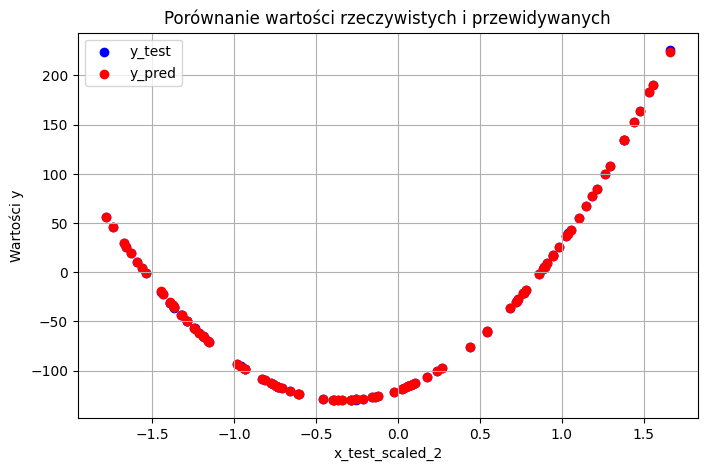

In [210]:
plot_results(x_test_scaled_1, y_test_1, y_predict_rescaled_1)

 # multimodal_large_training

In [211]:

neural_network_2 = NeuralNetwork2(layer_sizes=[1,16,16,16,1],
                                  activation='relu',
                                  output_activation='linear',
                                 init_method='he')


neural_network_2.params = read_dict('data/NN2/weights_multimodal_large.txt')

x_train_scaled_2, y_train_scaled_2, x_test_scaled_2, y_test_2, scaling_params_2 =  load_and_scale_data(multimodal_large_training, multimodal_large_test, 'x','y')



In [212]:
'''
weights_history_2, epoch_time_history_2, batch_time_history_2 =  neural_network_2.train(x_train_scaled_2, y_train_scaled_2, batch_size = 100 ,epochs = 100, learning_rate=0.01, save_weights_history=True, measure_time=True,verbose=10)
'''

'\nweights_history_2, epoch_time_history_2, batch_time_history_2 =  neural_network_2.train(x_train_scaled_2, y_train_scaled_2, batch_size = 100 ,epochs = 100, learning_rate=0.01, save_weights_history=True, measure_time=True,verbose=10)\n'

In [213]:
y_predict_2 = neural_network_2.forward(x_test_scaled_2)
y_test_mean_2 = scaling_params_2[2]
y_test_sd_2 = scaling_params_2[3]
y_predict_rescaled_2 = y_predict_2 * y_test_sd_2 + y_test_mean_2
neural_network_2.compute_loss(y_test_2, y_predict_rescaled_2)

np.float64(1.6731986326417039)

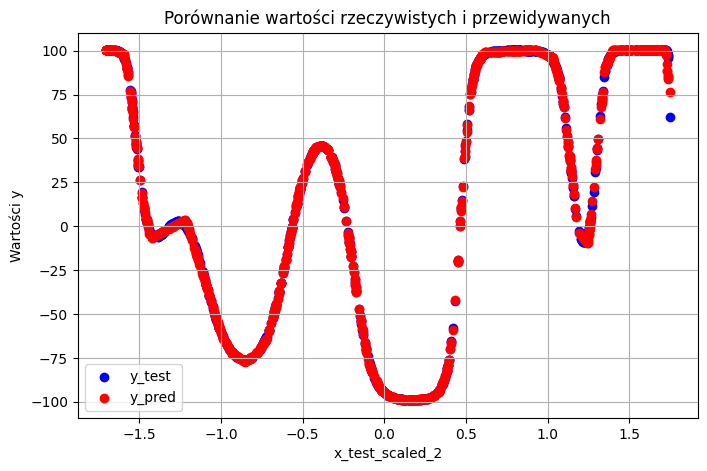

In [214]:
plot_results(x_test_scaled_2, y_test_2, y_predict_rescaled_2)

## batch / epoch analiza czasu



In [215]:
neural_network_batch_analysis = NeuralNetwork2(layer_sizes=[1,16,16,16,1],activation='relu',
                                              output_activation='linear',
                                              init_method='he')

# Konfiguracje – pięć niezależnych treningów z różnymi wartościami batch_size
configs = [
    {"epochs": 100, "batch_size": 100},
    {"epochs": 100, "batch_size": 50},
    {"epochs": 100, "batch_size": 10},
    {"epochs": 100, "batch_size": 5},
    {"epochs": 100, "batch_size": 1}
]

results = []  # lista do przechowywania wyników dla każdej konfiguracji

# Pętla treningowa – trenujemy 5 niezależnych sieci
for config in configs:


    # Trenujemy sieć z aktualną konfiguracją
    weights_history, epoch_time_history, batch_time_history = neural_network_batch_analysis.train(
        x_train_scaled_2,
        y_train_scaled_2,
        batch_size=config["batch_size"],
        epochs=config["epochs"],
        learning_rate=0.05,
        save_weights_history=True,
        measure_time=True,
        verbose=2500
    )

    # Obliczamy całkowity czas treningu (suma czasów poszczególnych epok)
    total_time = sum(epoch_time_history)


    # Zapisujemy wyniki wraz z konfiguracją
    results.append({
        "epochs": config["epochs"],
        "batch_size": config["batch_size"],
        "total_time": total_time,
        "avg_time_per_batch": np.mean([np.mean(batches) for batches in batch_time_history])

})

# Tworzymy DataFrame z uzyskanymi wynikami
df_results = pd.DataFrame(results)
df_results = df_results[["epochs", "batch_size", "total_time", "avg_time_per_batch"]]
display(df_results)


Epoch 1/100, Loss: 0.4031044360486858
Final Loss: 0.0256449226748161
Epoch 1/100, Loss: 0.05397758743948607
Final Loss: 0.005069250752031311
Epoch 1/100, Loss: 0.06423066893761815
Final Loss: 0.0014468395040807497
Epoch 1/100, Loss: 0.005811750474719728
Final Loss: 0.001489734554538838
Epoch 1/100, Loss: 0.03030545355041533
Final Loss: 0.06612459746510985


,epochs,batch_size,total_time,avg_time_per_batch
0,100,100,3.09338,0.00030
1,100,50,5.20281,0.00026
2,100,10,25.85712,0.00026
3,100,5,52.30975,0.00026
4,100,1,253.18128,0.00025


## Wizualizacje

- Testowałem wizualizację wartości wag i biasów poprzez mapowanie intensywności koloru, jednak okazało się to mało przydatne.
- Najbardziej wartościowa okazała się **wizualizacja wartości `y_test` i `y_pred`**.
- Dzięki niej zauważyłem, że w `x_test` znajdowały się próbki, których nie było w `x_train`.
- To powodowało niestabilność modelu i uniemożliwiało osiągnięcie akceptowalnej wartości funkcji straty (loss).

W przypadku dwóch pozostałych zadań aproksymacji, porównanie `y_test` oraz `y_pred` pozwoliło:
- Ocenić, czy model nie jest zbyt prosty.
- Stwierdzić, czy wpadł w słabe minima lokalne.

Z tego względu dodatkowe wizualizacje nie były konieczne.
